## **Environment Setup**

In [1]:
import os 
os.chdir ('../src')

## **Importing Libraries**

In [2]:
from init import pd, nlp, tqdm, nx, plt
from knowledge_graph import get_entities, get_relation

In [3]:
pd.set_option('display.max_colwidth', 200)

In [4]:
ROOT_PATH = '/run/media/sri/OS/Users/sriva/Desktop/Sem 5/'
ROOT_PATH += 'Knowledge Representation/Project/'
ROOT_PATH += 'Complex-Question-Answering-using-Knowledge-Graphs/'

## **Reading the data**

In [5]:
candidate_sentences = pd.read_csv(ROOT_PATH + "data/wiki_sentences_v2.csv")
candidate_sentences = candidate_sentences.head(100)

## **Getting Entity Pairs**

In [6]:
entity_pairs = []

In [7]:
for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 100/100 [00:00<00:00, 160.17it/s]


In [8]:
for i in range(10):
    print(entity_pairs[i])

['connie', 'own']
['later  scream', 'distance']
['christian', 'then  elder']
['temple', 'fire']
['', 'outside cult him']
['it', 'religious  awakening']
['c. mackenzie', 'craig cast']
['later craig di francia', 'action cast']
['sebastian  maniscalco', 'later paul ben cast']
['we', 'just  film']


In [9]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 100/100 [00:00<00:00, 171.19it/s]


In [10]:
pd.Series(relations).value_counts()[:50]

released                4
is                      4
scheduled               2
did                     2
presented in            2
wait                    2
was                     2
joined                  2
tend                    1
oversee                 1
offered in              1
use different           1
attended                1
includes                1
started as              1
start in                1
credited                1
supervises              1
include                 1
had many                1
include limited         1
equipped with           1
are ready               1
are                     1
prevalent in typical    1
take                    1
decides                 1
designed for            1
produced by             1
cuts to                 1
look at                 1
shifts                  1
wall                    1
being                   1
suggested               1
were interested         1
been                    1
conducted by            1
reshoot     

## **Building a Knowledge Graph**

In [11]:
# extract subject
source = [i[0] for i in entity_pairs]

In [12]:
# extract object
target = [i[1] for i in entity_pairs]

In [13]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [14]:
kg_df

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with
...,...,...,...
95,,,wall
96,,violently camera left,shifts
97,couple,other,look at
98,camera,vestibule,cuts to


In [15]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

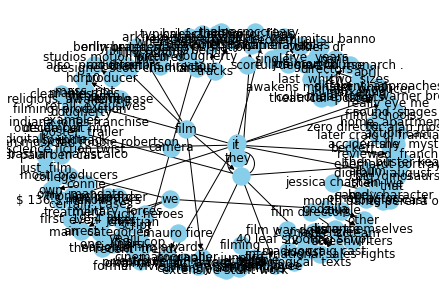

In [16]:
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

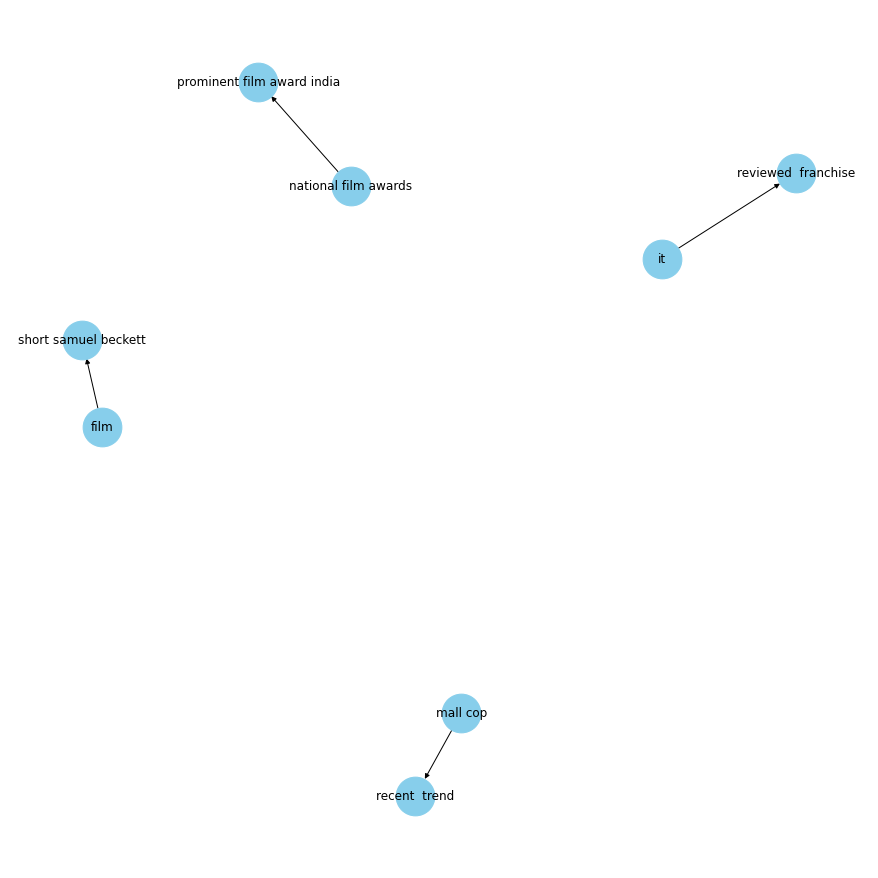

In [17]:
# is relationship

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [18]:
text = "What is mall cop?"

In [19]:
subject, _ = get_entities(text)

In [20]:
subject

'mall cop'

In [21]:
rel = get_relation(text)

In [22]:
rel

'is'

In [23]:
for i in range(kg_df.shape[0]):
    if kg_df.source[i] == subject and kg_df.edge[i] == rel:
        print(kg_df.target[i])
        break

recent  trend
